## Importing Libraries

In [259]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import seaborn as sns
import operator 
plt.style.use('ggplot')
%matplotlib inline 

## Importing the Updated Version of Data

In [260]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-16-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-16-2020.csv')

In [261]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-05-17 02:32:32,34.223334,-82.461707,34,0,0,34,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-05-17 02:32:32,30.295065,-92.414197,192,11,0,181,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-05-17 02:32:32,37.767072,-75.632346,668,9,0,659,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-05-17 02:32:32,43.452658,-116.241552,773,22,0,751,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-05-17 02:32:32,41.330756,-94.471059,4,0,0,4,"Adair, Iowa, US"


In [262]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,850,856,868,872,876,880,898,916,933,946
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,752,754,755,755,758,760,761,761,761,761
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,43,43,45,45,45,45,48,48,48,48


In [263]:
us_medical_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-05-17 02:32:37,32.3182,-86.9023,11674,485,NaN,11189.0,1,238.090139,153494.0,1387.0,4.154531,84000001,USA,3130.495790,11.881103
1,Alaska,US,2020-05-17 02:32:37,61.3707,-152.4044,388,10,344.0,34.0,2,53.038432,33281.0,NaN,2.577320,84000002,USA,4549.412545,NaN
2,American Samoa,US,2020-05-17 02:32:37,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,105.0,NaN,NaN,16,ASM,188.709764,NaN
3,Arizona,US,2020-05-17 02:32:37,33.7298,-111.4312,13666,679,3357.0,9630.0,4,187.752869,146788.0,1683.0,4.968535,84000004,USA,2016.674092,12.315235
4,Arkansas,US,2020-05-17 02:32:37,34.9697,-92.3731,4578,98,3472.0,1008.0,5,151.699713,81644.0,520.0,2.140673,84000005,USA,2705.410954,11.358672


### Data Pre-processing for Modelling and Exploratory Analysis

In [264]:
cols = confirmed_df.keys()

In [265]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]
confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
0,0,0,0,0,0,0,0,0,0,0,...,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664
1,0,0,0,0,0,0,0,0,0,0,...,850,856,868,872,876,880,898,916,933,946
2,0,0,0,0,0,0,0,0,0,0,...,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019
3,0,0,0,0,0,0,0,0,0,0,...,752,754,755,755,758,760,761,761,761,761
4,0,0,0,0,0,0,0,0,0,0,...,43,43,45,45,45,45,48,48,48,48


In [339]:
countries=['china','italy','us','spain','france','germany','uk','russia','brazil','india','australia']
g = globals()
def init_lists(string):
    ''' initialize the name of lists for each country for 
    confirmed, death, and recovery cases'''
    
    for i in countries:
        g['{0}_{1}'.format(i,string)] = []

In [340]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

#Initializing all the lists
init_lists('cases')
init_lists('deaths')
init_lists('recoveries')

values=['China','Italy','US','Spain','France','Germany','United Kingdom','Russia','Brazil','India','Australia']

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculating the mortality and recovery rate
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # getting the confirmed, deaths, and recovered, for each country
    for j in range(len(countries)):
        g['{0}_{1}'.format(countries[j],'cases')].append(confirmed_df[confirmed_df['Country/Region']==values[j]][i].sum())
        g['{0}_{1}'.format(countries[j],'deaths')].append(deaths_df[deaths_df['Country/Region']==values[j]][i].sum())
        g['{0}_{1}'.format(countries[j],'recoveries')].append(recoveries_df[recoveries_df['Country/Region']==values[j]][i].sum())

In [341]:
ls=[world_cases, total_deaths, total_recovered, total_active]
df=pd.DataFrame(ls)
df=df.T
df.columns=['confirmed','death','recovered','active']
df

,confirmed,death,recovered,active
0,555,17,28,510
1,654,18,30,606
2,941,26,36,879
3,1434,42,39,1353
4,2118,56,52,2010
5,2927,82,61,2784
6,5578,131,107,5340
7,6166,133,126,5907
8,8234,171,143,7920
9,9927,213,222,9492


In [269]:
df=df.shift(periods=1, freq=None, axis=0)
df=df.fillna(0)
df.head()

,confirmed,death,recovered,active
0,0.0,0.0,0.0,0.0
1,555.0,17.0,28.0,510.0
2,654.0,18.0,30.0,606.0
3,941.0,26.0,36.0,879.0
4,1434.0,42.0,39.0,1353.0


### Finding the daily increase globally and country-wise

In [342]:
def daily_increase(data):
    '''Getting the daily increase in the confirmed, recovered, death, and total cases
    for each country as well as globally'''
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)

#death cases
world_daily_death = daily_increase(total_deaths)

#recovery cases
world_daily_recovery = daily_increase(total_recovered)
g_increase = globals()
#getting country-wise increase in confirmed, death, and recovery cases
for i in countries:
    g_increase['{0}_{1}'.format(i,'daily_increase')] = daily_increase(g['{0}_{1}'.format(i,'cases')])
    g_increase['{0}_{1}'.format(i,'daily_death')] = daily_increase(g['{0}_{1}'.format(i,'deaths')])
    g_increase['{0}_{1}'.format(i,'daily_recovery')] = daily_increase(g['{0}_{1}'.format(i,'recoveries')])
    

In [343]:
#formatting dataframes for further analysis
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [344]:
days_since_1_22

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [345]:
df['label']=total_active
df['days']=days_since_1_22

df.head()

,confirmed,death,recovered,active,label,days
0,555,17,28,510,510,0
1,654,18,30,606,606,1
2,941,26,36,879,879,2
3,1434,42,39,1353,1353,3
4,2118,56,52,2010,2010,4


In [275]:
### Forcasting for future dates
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [276]:
future_forcast

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [277]:
## convert integer to datetime format for better visualization
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [278]:
X_train_confirmed, X_test_confirmed = train_test_split(df, test_size=0.20, shuffle=False) 

In [279]:
X_train_confirmed.head()

,confirmed,death,recovered,active,label,days
0,0.0,0.0,0.0,0.0,510,0
1,555.0,17.0,28.0,510.0,606,1
2,654.0,18.0,30.0,606.0,879,2
3,941.0,26.0,36.0,879.0,1353,3
4,1434.0,42.0,39.0,1353.0,2010,4


In [280]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
data_normalized_train = scalar.fit_transform(X_train_confirmed.iloc[:, :-1])
data_normalized_test=scalar.transform(X_test_confirmed.iloc[:, :-1])
train=np.concatenate((X_train_confirmed.iloc[:, -1 :], data_normalized_train), axis = 1)
test=np.concatenate((X_test_confirmed.iloc[:, -1:], data_normalized_test), axis = 1)

In [281]:
X_train=train[:, :-1]
X_test=test[:, :-1]
y_train=train[:, -1:]
y_test=test[:, -1:]

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [282]:
# # use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [283]:
# svm_search.best_params_

In [284]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_confirmed.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)

//anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=0.1, cache_size=200, coef0=0.0, degree=4, epsilon=1, gamma=0.01,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 0.9164044139044644
MSE: 0.8547164339549824


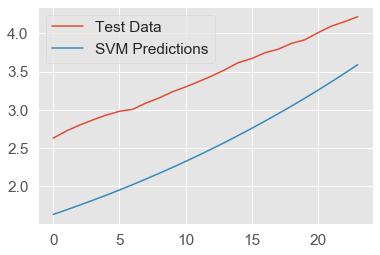

In [285]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test)
plt.plot(y_test)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test))
print('MSE:',mean_squared_error(svm_test_pred, y_test))

In [157]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
#poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train = bayesian_poly.fit_transform(X_train)
bayesian_poly_X_test = bayesian_poly.fit_transform(X_test)
#bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [161]:
# polynomial regression
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_train, y_train)
test_linear_pred = linear_model.predict(X_test)
#linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test))
print('MSE:',mean_squared_error(test_linear_pred, y_test))

MAE: 0.056878664841151116
MSE: 0.005025474152760919


In [20]:
print(linear_model.coef_)

[[-7.04183200e+04  1.88211771e+04 -7.98481865e+02  1.01896821e+01]]


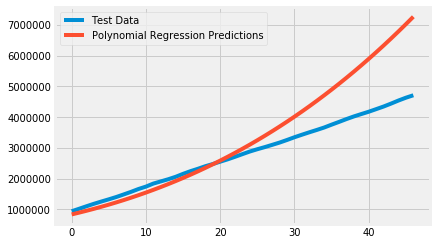

In [21]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [22]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [23]:
bayesian_search.best_params_

{'tol': 0.01,
 'normalize': True,
 'lambda_2': 1e-07,
 'lambda_1': 1e-07,
 'alpha_2': 0.001,
 'alpha_1': 0.001}

In [24]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 578092.6982315414
MSE: 684978409003.7366


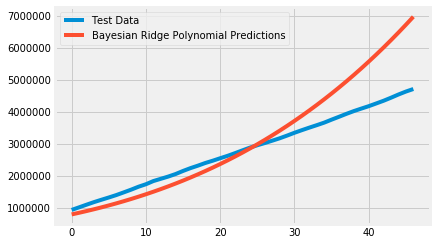

In [25]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

#  Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate
 <a id='world_wide_graphs'></a>

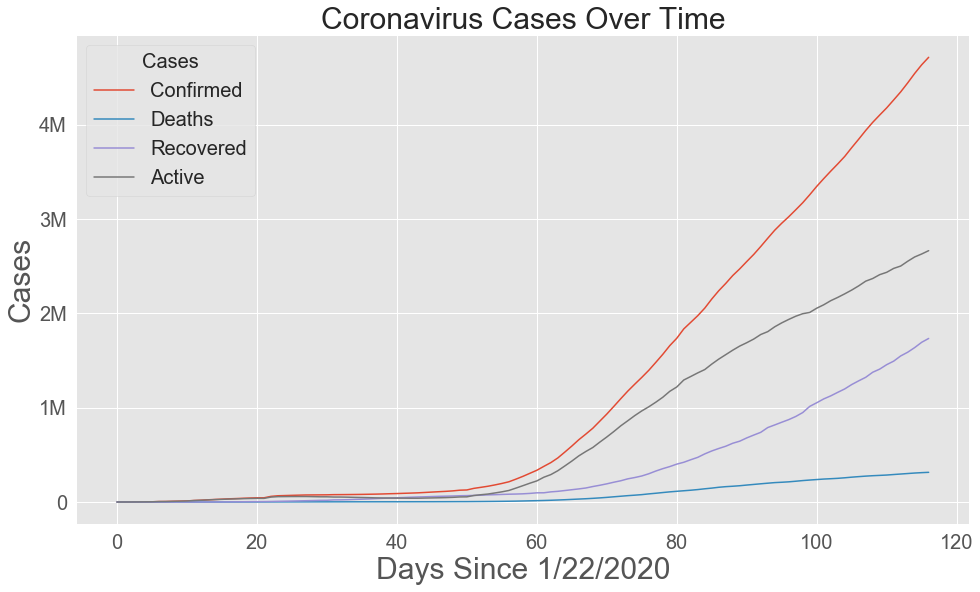

In [346]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases,label='Confirmed')
plt.plot(adjusted_dates, total_deaths,label='Deaths')
plt.plot(adjusted_dates, total_recovered,label='Recovered')
plt.plot(adjusted_dates, total_active,label='Active')
plt.title('Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc='best',title="Cases",fontsize=20,title_fontsize=20)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
plt.show()

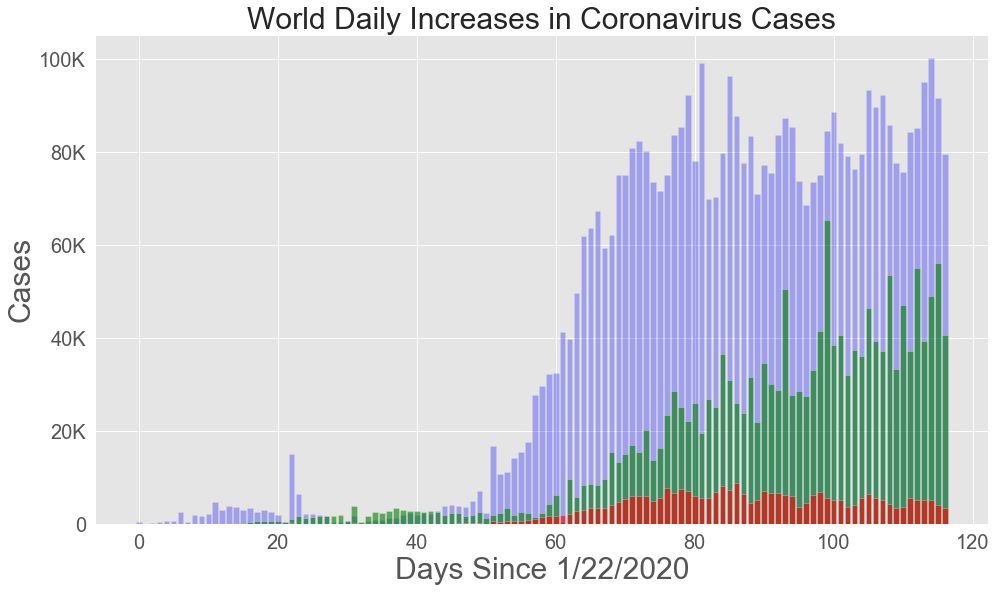

In [347]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase,color='blue',alpha=0.3,label="confirmed")
plt.bar(adjusted_dates, world_daily_recovery,color='green',alpha=0.6,label="recovery")
plt.bar(adjusted_dates, world_daily_death,color='red',alpha=0.6,label="death")
plt.title('World Daily Increases in Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

In [348]:
def country_plot(x, y1, y2, y3, y4, country):
    plt.figure(figsize=(16, 9))
    plt.bar(x, y2,color='blue',alpha=0.3,label="confirmed")
    plt.bar(x, y4,color='green',alpha=0.6,label="recovery")
    plt.bar(x, y3,color='red',alpha=0.6,label="death")
    plt.title('Daily Increases in Cases in {}'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.legend(loc='best')
    plt.show()

In [362]:
countries

['china',
 'italy',
 'us',
 'spain',
 'france',
 'germany',
 'uk',
 'russia',
 'brazil',
 'india',
 'australia']

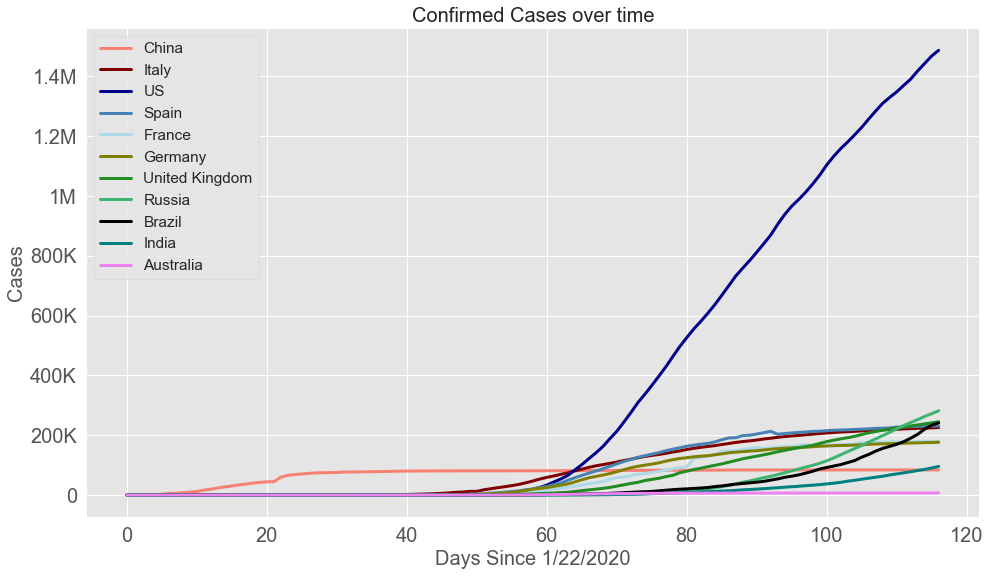

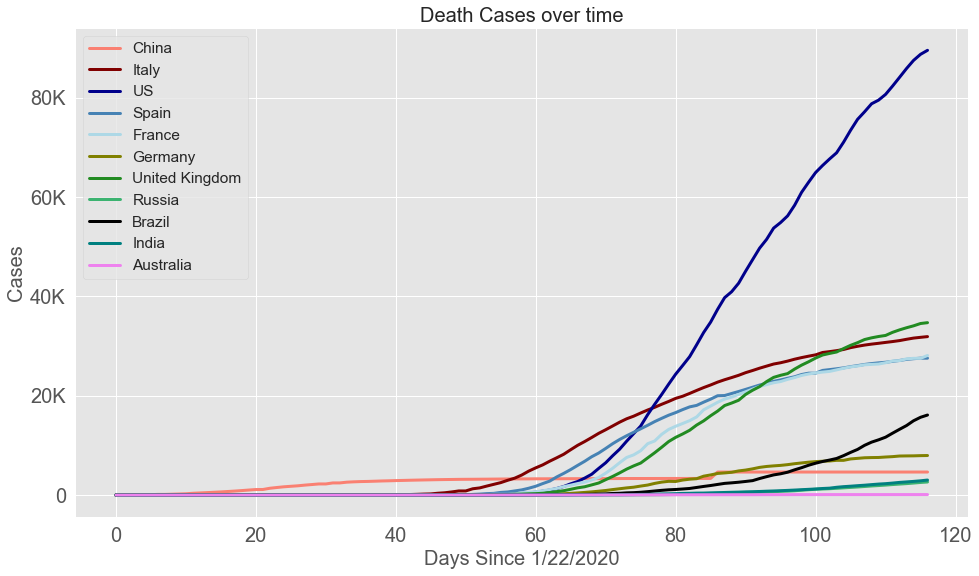

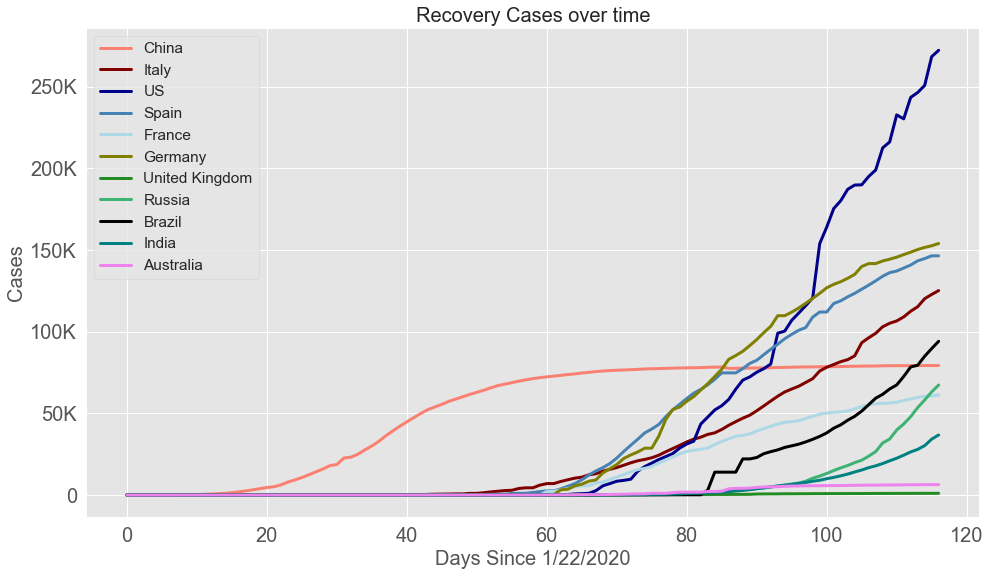

In [366]:
def country_plot_line(x):
    colors=['salmon','maroon','darkblue','steelblue','lightblue','olive','forestgreen','mediumseagreen',
           'black','teal','violet']
    fig=plt.figure(figsize=(16, 9))
    for i in range(len(countries)):
        y1=g['{0}_{1}'.format(countries[i],'cases')]
        plt.plot(x, y1,label=values[i],color=colors[i],linewidth=3)
        plt.title('Confirmed Cases over time', size=20)
        plt.xlabel('Days Since 1/22/2020', size=20)
        plt.ylabel('Cases', size=20)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.legend(loc='best')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
    plt.show()

    plt.figure(figsize=(16, 9))
    for i in range(len(countries)):
        y1=g['{0}_{1}'.format(countries[i],'deaths')]
        plt.plot(x, y1,label=values[i],color=colors[i],linewidth=3)
        plt.title('Death Cases over time', size=20)
        plt.xlabel('Days Since 1/22/2020', size=20)
        plt.ylabel('Cases', size=20)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.legend(loc='best')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
    plt.show()
    
    plt.figure(figsize=(16, 9))
    for i in range(len(countries)):
        y1=g['{0}_{1}'.format(countries[i],'recoveries')]
        plt.plot(x, y1,label=values[i],color=colors[i],linewidth=3)
        plt.title('Recovery Cases over time', size=20)
        plt.xlabel('Days Since 1/22/2020', size=20)
        plt.ylabel('Cases', size=20)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.legend(loc='best')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
    plt.show()
country_plot_line(adjusted_dates)

# Country Specific Graphs
<a id='country_graphs'></a>

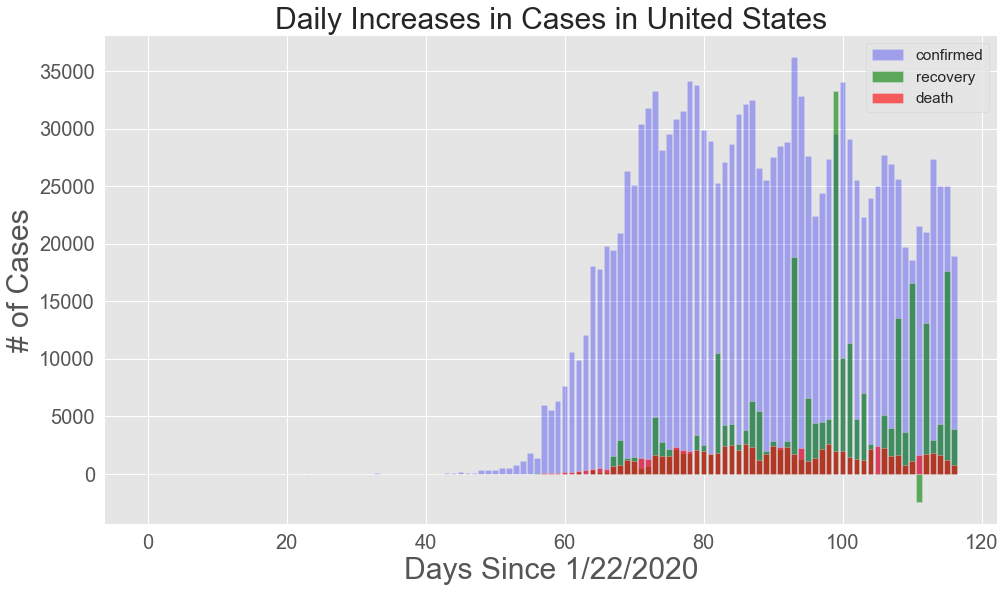

In [328]:
country_plot(adjusted_dates, us_cases, us_daily_increase, us_daily_death, us_daily_recovery, 'United States')

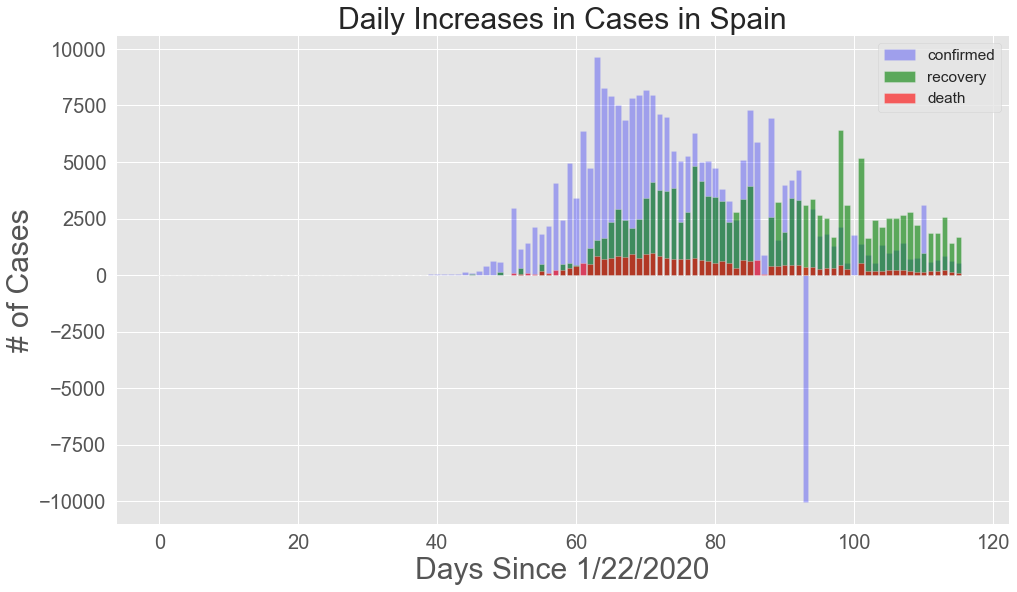

In [329]:
country_plot(adjusted_dates, spain_cases, spain_daily_increase, spain_daily_death, spain_daily_recovery, 'Spain')

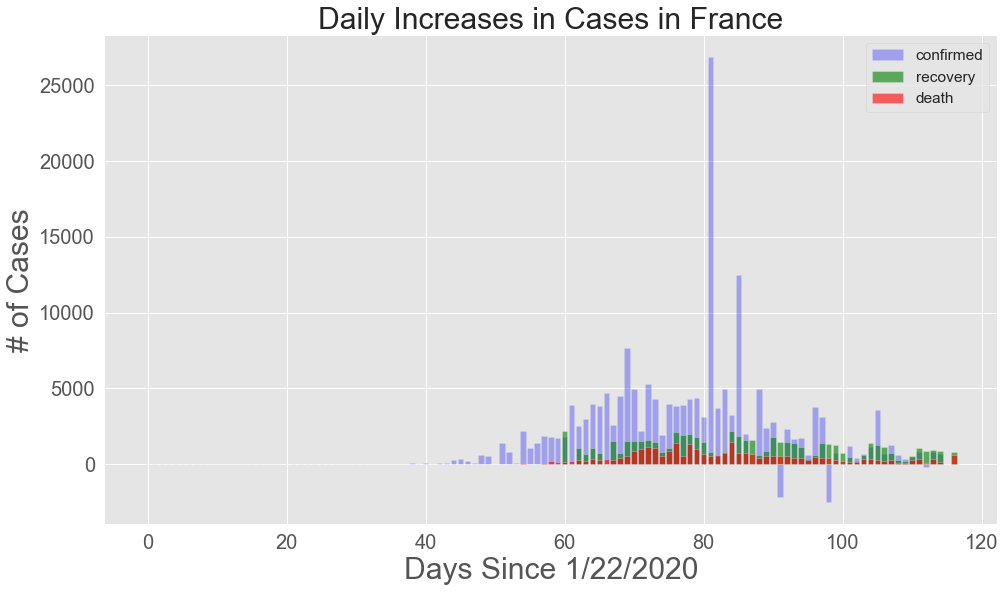

In [330]:
country_plot(adjusted_dates, france_cases, france_daily_increase, france_daily_death, france_daily_recovery, 'France')

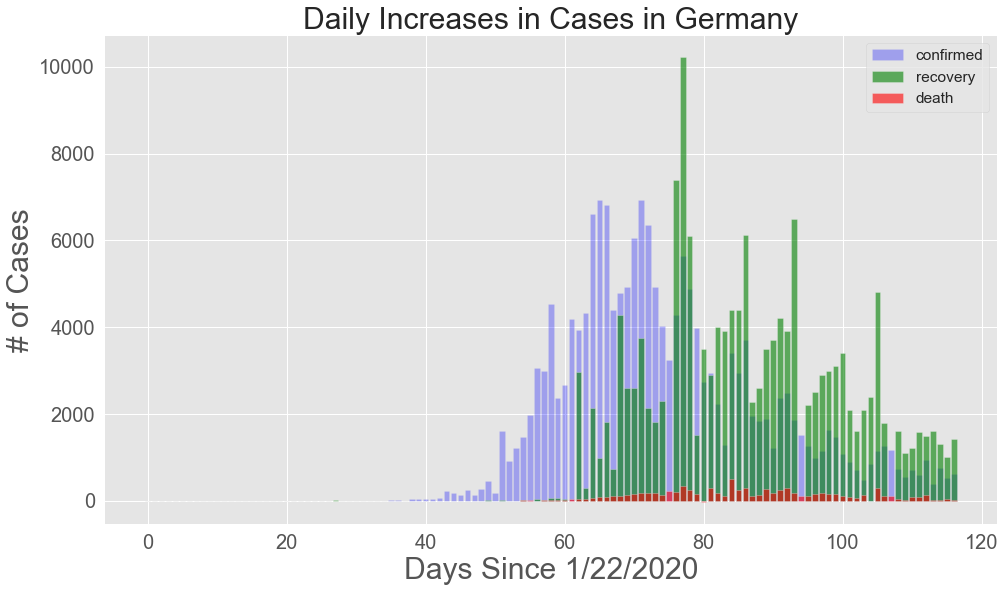

In [331]:
country_plot(adjusted_dates, germany_cases, germany_daily_increase, germany_daily_death, germany_daily_recovery, 'Germany')

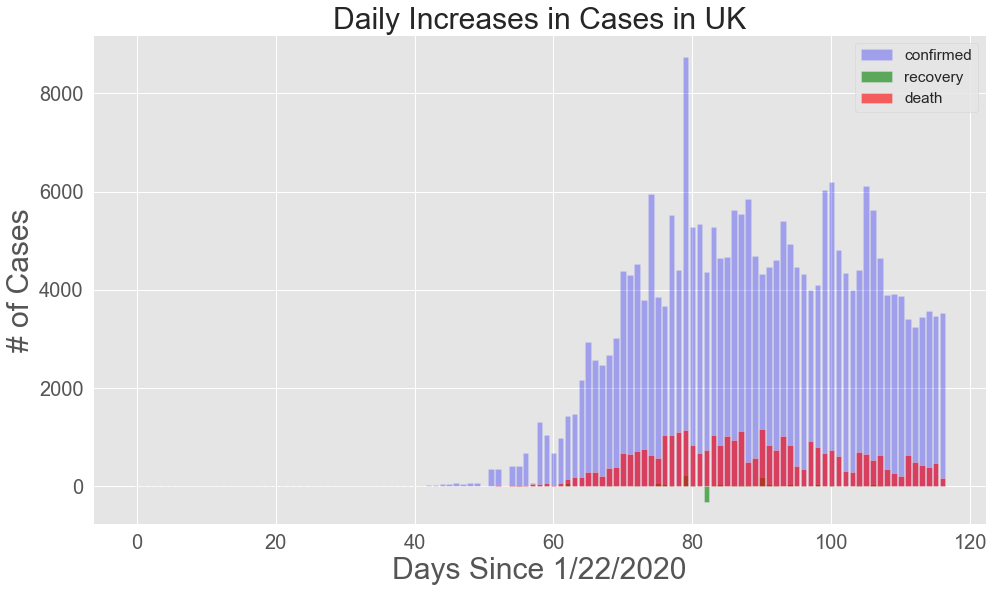

In [332]:
country_plot(adjusted_dates, uk_cases, uk_daily_increase, uk_daily_death, uk_daily_recovery, 'UK')

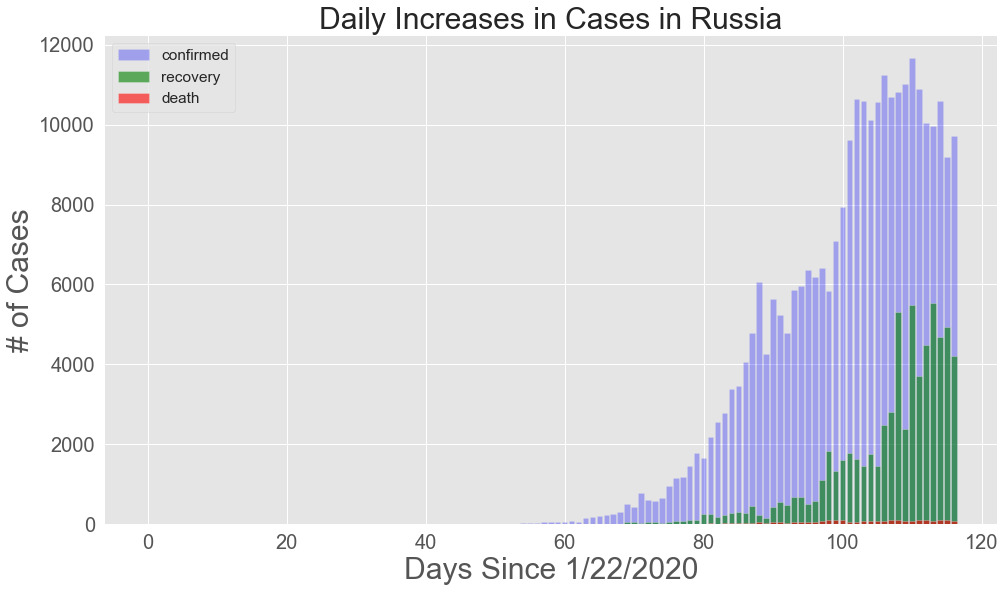

In [333]:
country_plot(adjusted_dates, russia_cases, russia_daily_increase, russia_daily_death, russia_daily_recovery, 'Russia')

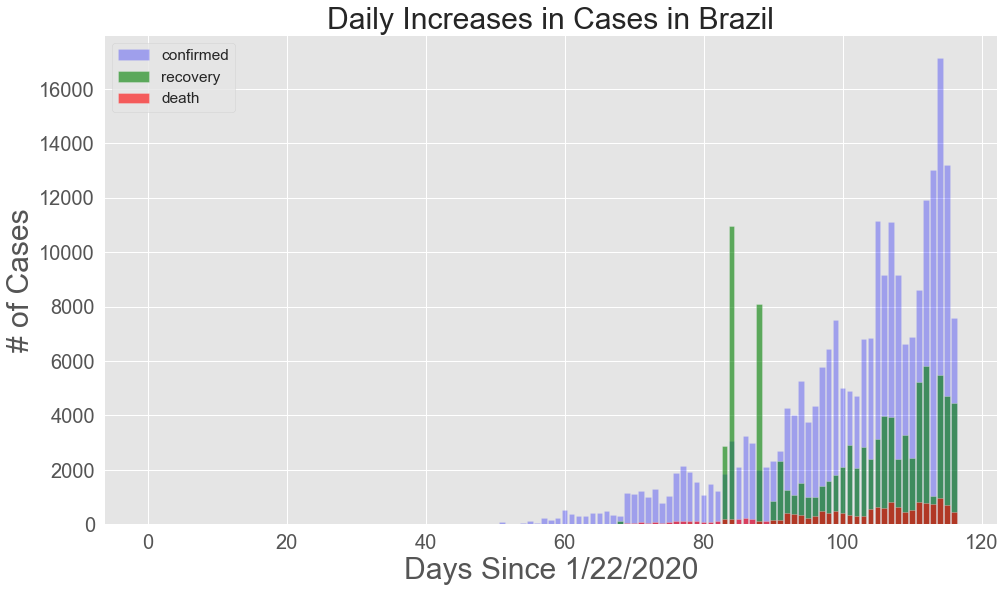

In [334]:
country_plot(adjusted_dates, brazil_cases, brazil_daily_increase, brazil_daily_death, brazil_daily_recovery, 'Brazil')

Mortality Rate (worldwide) **susceptible to change **

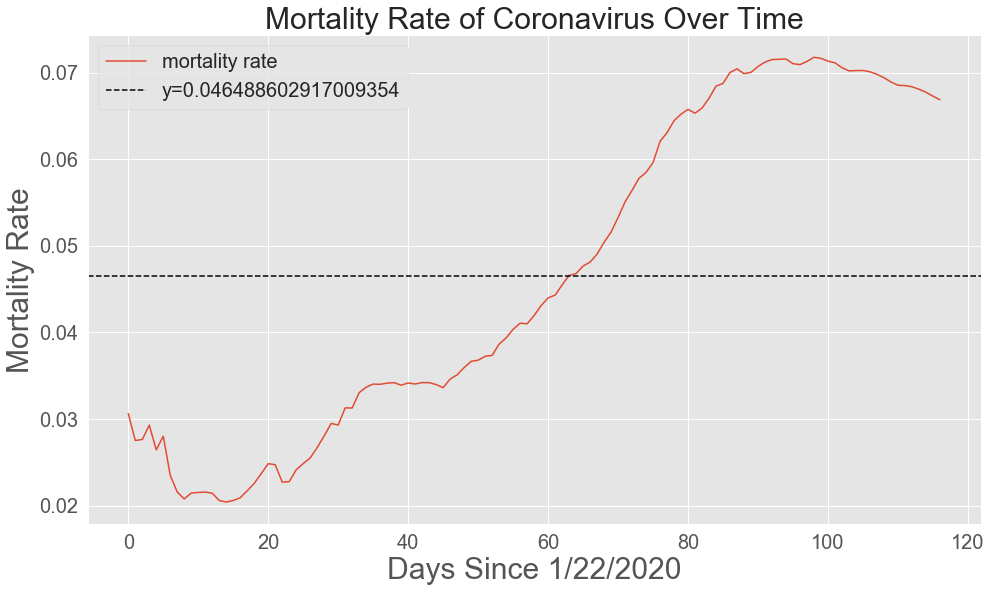

In [392]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate)
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Recovery Rate (worldwide) **suceptible to change **

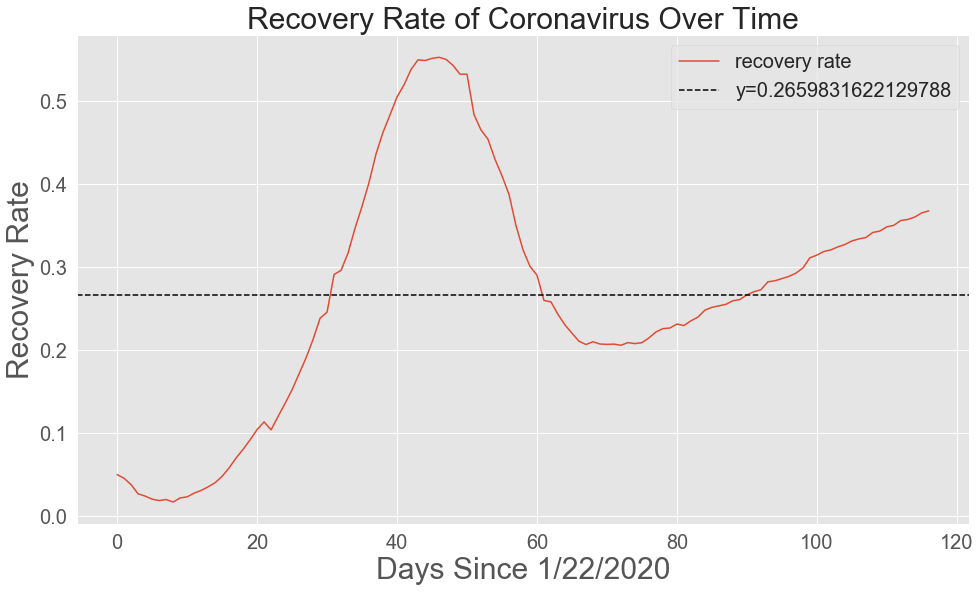

In [391]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate)
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Getting information about countries/regions that have confirmed coronavirus cases

In [369]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [370]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

# Data table
<a id='data_table'></a>

In [393]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Blues')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,1467820,88754,268376,1110690,0.0604665
1,Russia,272043,2537,63166,206340,0.00932573
2,United Kingdom,241461,34546,1058,205857,0.143071
3,Brazil,233511,15662,89672,128177,0.0670718
4,Spain,230698,27563,146446,56689,0.119477
5,Italy,224760,31763,122810,70187,0.14132
6,France,179630,27532,60562,91536,0.153271
7,Germany,175752,7938,152600,15214,0.0451659
8,Turkey,148067,4096,108137,35834,0.0276632
9,Iran,118392,6937,93147,18308,0.0585935


In [394]:
unique_provinces =  list(latest_data['Province_State'].unique())

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [395]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [397]:
# number of cases per province/state/city
province_df = pd.DataFrame({'Province/State Name': unique_provinces, 'Country': province_country, 'Number of Confirmed Cases': province_confirmed_cases,
                          'Number of Deaths': province_death_cases, 'Number of Recoveries' : province_recovery_cases,
                          'Mortality Rate': province_mortality_rate})
# number of cases per country/region

province_df.style.background_gradient(cmap='Reds')

,Province/State Name,Country,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Mortality Rate
0,New York,US,348232,28049,0,0.0805469
1,New Jersey,US,145089,10261,0,0.0707221
2,Illinois,US,92457,4129,0,0.0446586
3,Massachusetts,US,84933,5705,0,0.0671706
4,Lombardia,Italy,84518,15450,41389,0.182801
5,California,US,78725,3208,0,0.0407494
6,Hubei,China,68134,4512,63616,0.0662224
7,Madrid,Spain,66210,8826,40586,0.133303
8,Pennsylvania,US,65185,4480,0,0.0687275
9,Catalonia,Spain,55685,5915,26067,0.106223


In [376]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

<a id='bar_charts'></a>
# Comparison with China

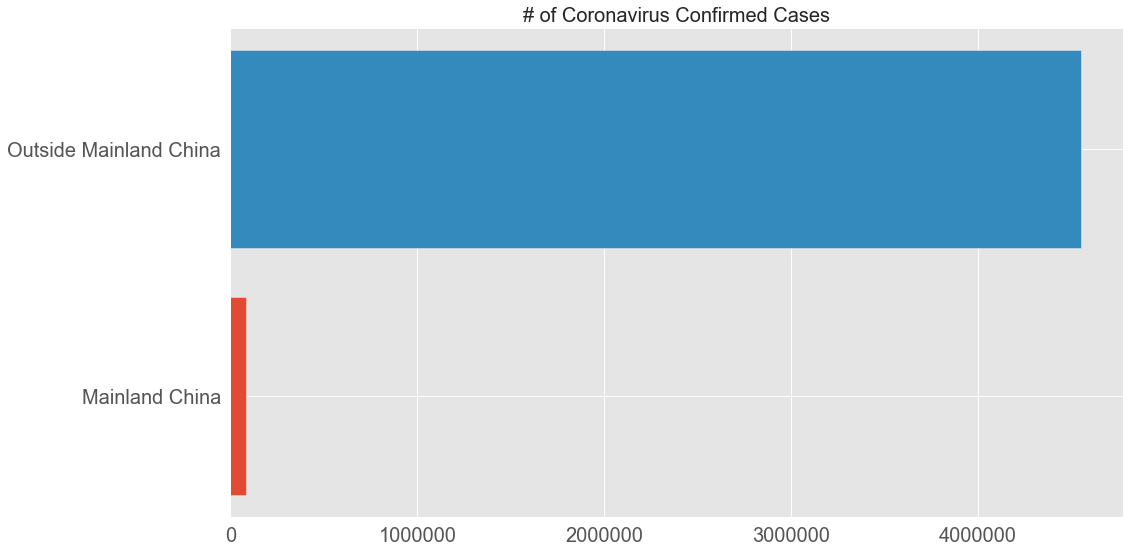

In [398]:
china_confirmed = latest_data[latest_data['Country_Region']=='China']['Confirmed'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [399]:
print('Outside Mainland China: {} cases'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

Outside Mainland China: 4550024 cases
Mainland China: 84044 cases
Total: 4634068 cases


In [379]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

***Visual Representations*** (bar charts and pie charts)

In [402]:
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=(16, 9))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

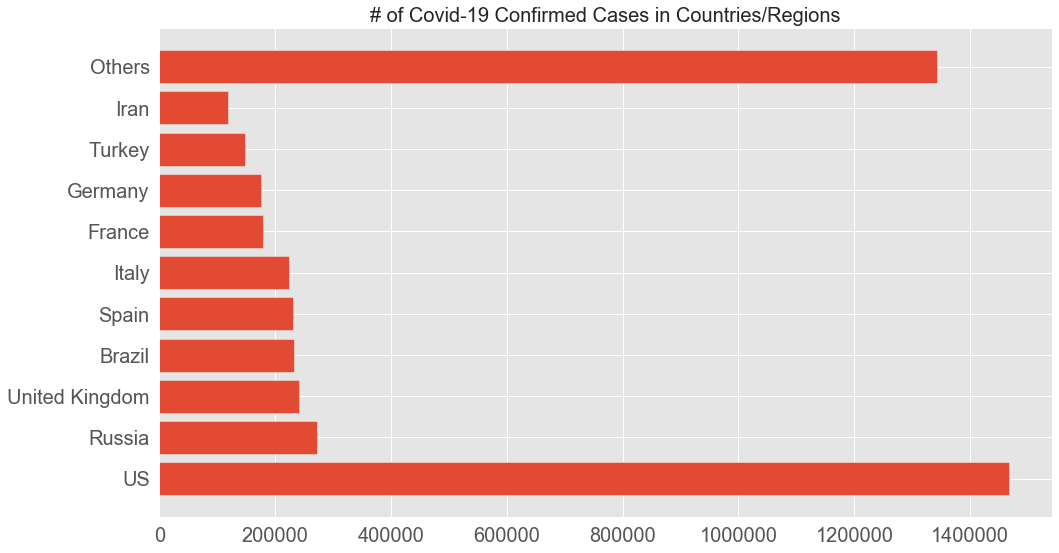

In [403]:
plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

In [383]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

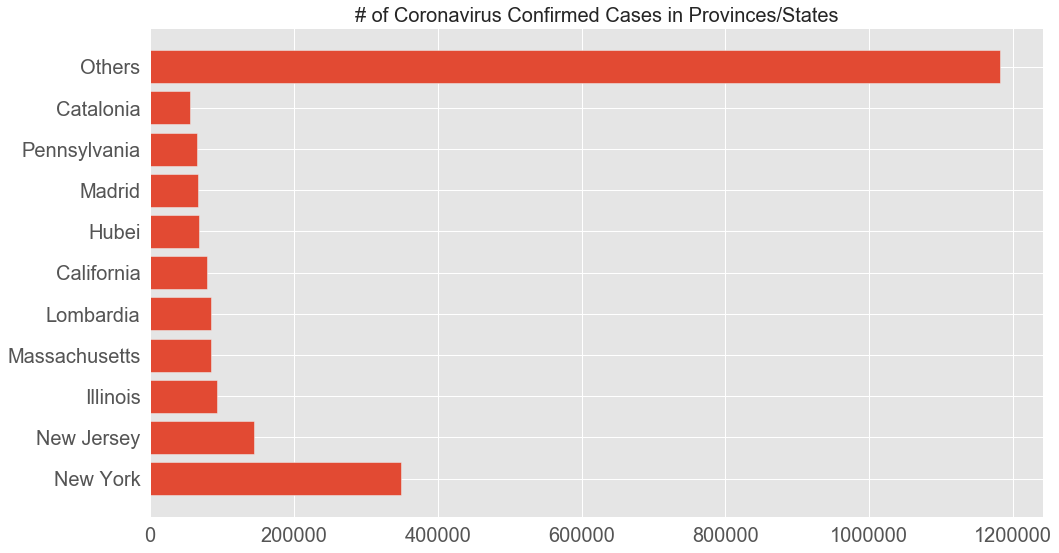

In [384]:
plot_bar_graphs(visual_unique_provinces, visual_confirmed_cases2, '# of Coronavirus Confirmed Cases in Provinces/States')

<a id='hospital_testing'></a>
# US Medical Data on Testing and Hosptialization

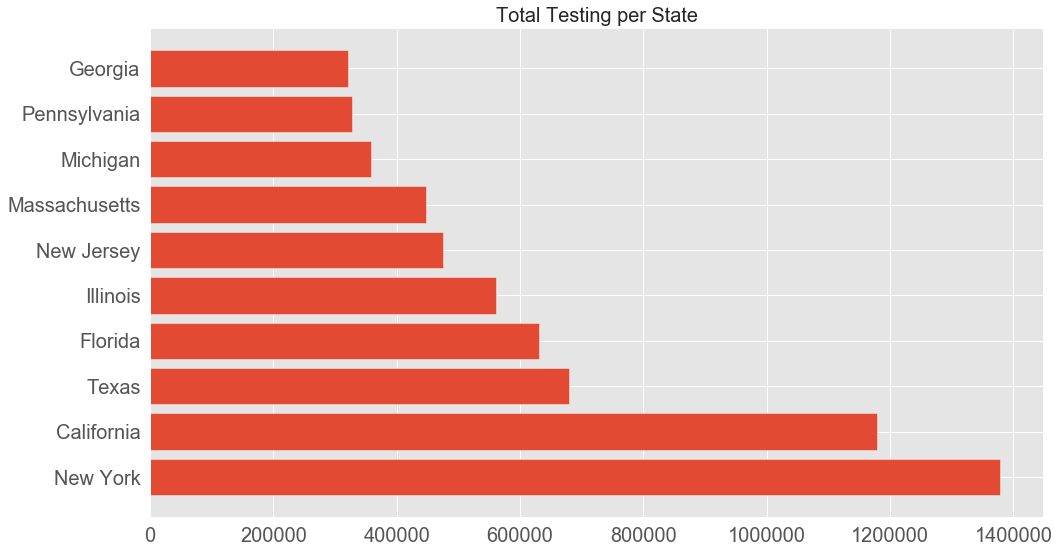

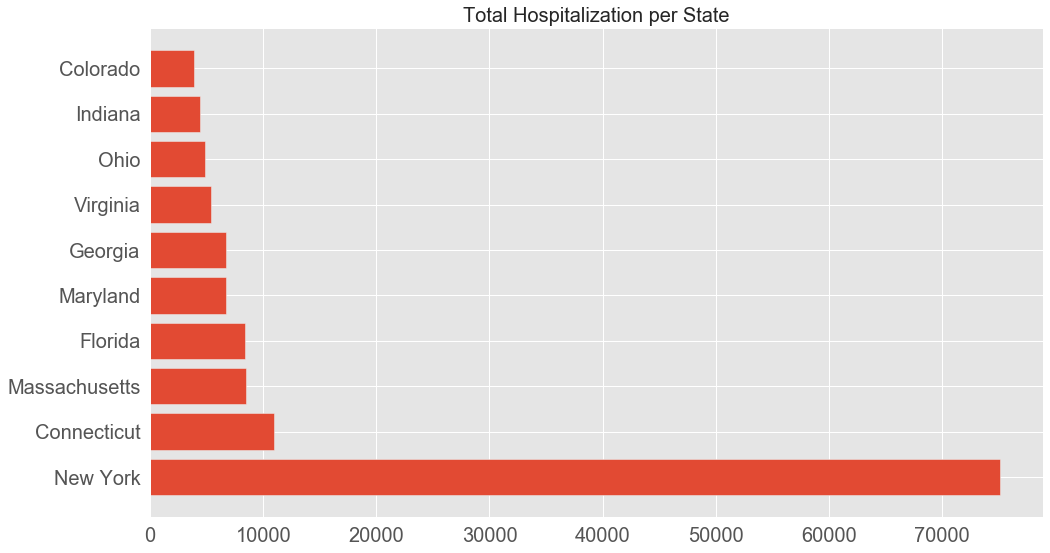

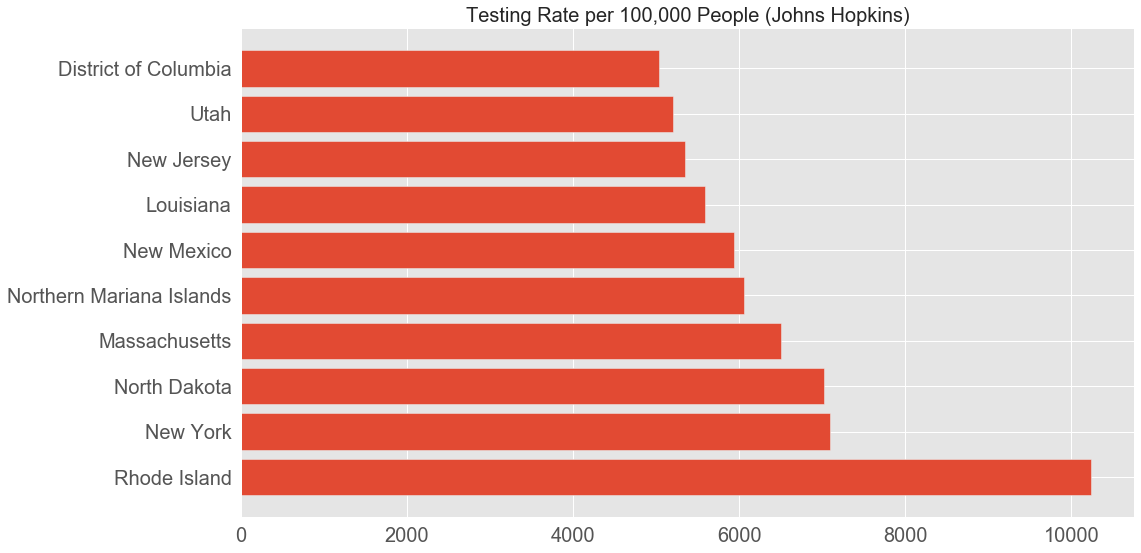

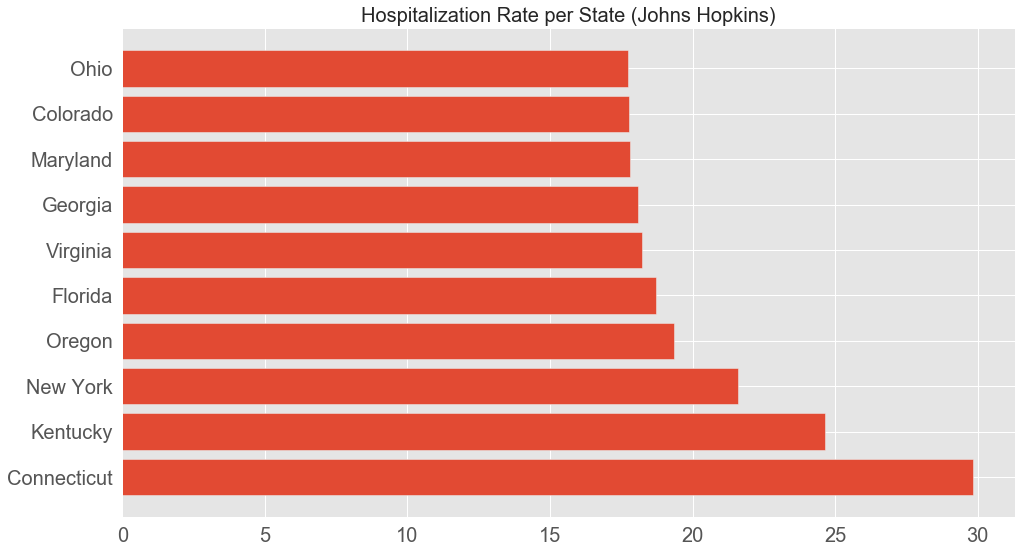

In [387]:
# Replace nan with 0
us_medical_data.fillna(value=0, inplace=True)

def plot_us_medical_data():
    states = us_medical_data['Province_State'].unique()
    testing_number = []
    hospitalization_number = [] 
    testing_rate = []
    hospitalization_rate = []
    
    for i in states:
        testing_number.append(us_medical_data[us_medical_data['Province_State']==i]['People_Tested'].sum())
        hospitalization_number.append(us_medical_data[us_medical_data['Province_State']==i]['People_Hospitalized'].sum())
        testing_rate.append(us_medical_data[us_medical_data['Province_State']==i]['Testing_Rate'].max())
        hospitalization_rate.append(us_medical_data[us_medical_data['Province_State']==i]['Hospitalization_Rate'].max())
    
    # only show the top 10 states
    testing_states = [k for k, v in sorted(zip(states, testing_number), key=operator.itemgetter(1), reverse=True)]
    hospitalization_states = [k for k, v in sorted(zip(states, hospitalization_number), key=operator.itemgetter(1), reverse=True)]
    testing_rate_states = [k for k, v in sorted(zip(states, testing_rate), key=operator.itemgetter(1), reverse=True)]
    hospitalization_rate_states = [k for k, v in sorted(zip(states, hospitalization_rate), key=operator.itemgetter(1), reverse=True)]
    
    for i in range(len(states)):
        testing_number[i] = us_medical_data[us_medical_data['Province_State']==testing_states[i]]['People_Tested'].sum()
        hospitalization_number[i] = us_medical_data[us_medical_data['Province_State']==hospitalization_states[i]]['People_Hospitalized'].sum()
        testing_rate[i] = us_medical_data[us_medical_data['Province_State']==testing_rate_states[i]]['Testing_Rate'].sum()
        hospitalization_rate[i] = us_medical_data[us_medical_data['Province_State']==hospitalization_rate_states[i]]['Hospitalization_Rate'].sum()
    
    plot_bar_graphs(testing_states[:10], testing_number[:10], 'Total Testing per State')
    plot_bar_graphs(hospitalization_states[:10], hospitalization_number[:10], 'Total Hospitalization per State')
    plot_bar_graphs(testing_rate_states[:10], testing_rate[:10], 'Testing Rate per 100,000 People (Johns Hopkins)')
    plot_bar_graphs(hospitalization_rate_states[:10], hospitalization_rate[:10], 'Hospitalization Rate per State (Johns Hopkins)')
    
plot_us_medical_data()